<img src="../../strathclyde_banner.png" alt="University of Strathclyde" width="50%">

# 1. Baseband Modulation

## Introduction

In the context of wireless communications, baseband modulation is distinct from, and takes place prior to, the modulation of a signals from baseband to Intermediate Frequency (IF) or Radio Frequency (RF). Baseband modulation is the mapping of data bits to symbols according to the baseband modulation scheme. In this notebook we will specifically cover the Phase Shift Keying (PSK) and Quadrature Amplitude Modulation (QAM) schemes. We will also talk about noise, such as Additive White Gaussian Noise (AWGN) and show common link quality evaluation metrics in Error Vector Magnitude (EVM) and Bit Error Rate (BER).

## Table of Contents

* [1.1 Baseband Modulation Schemes](#mod_schemes)
* [1.2 Noise and SNR](#snr)
* [1.3 Error Vector Magnitude](#evm)
* [1.4 Bit Error Rate](#ber)
* [1.5 Conclusion](#conclusion)

For this notebook we will be using NumPy for computation and Matplotlib for matlab-like visualizations of our waveforms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1.1 Baseband Modulation Schemes <a class="anchor" id="mod_schemes"></a>

**Binary Phase Shift Keying (BPSK)**

One of the most common modulation schemes is BPSK, where each bit is assigned one symbol. We start by generating some random bits.

In [2]:
bits = np.random.randint(0,2,16)
bits

array([0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0])

Now we can define the scheme as a simple Python list, and use list comprehension to map every bit to a symbol. Now our bits will be mapped to the desired symbols.

In [3]:
bpsk_scheme = [-1+0j, 1+0j]
bpsk_symbols = [bpsk_scheme[i] for i in bits]

We can plot our BPSK 'modulated' data on a constellation map. Note that they appear as dots on the horizontal plane, as BPSK only includes the real (I) component. Changes between these symbols are equivalent to a phase change of 180 degrees.

Text(0, 0.5, 'Channel 2 amplitude')

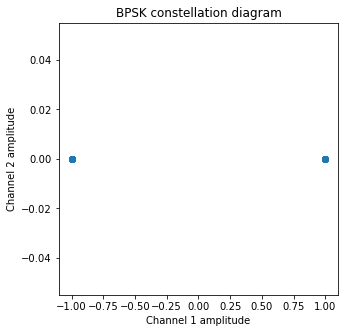

In [11]:
plt.figure(figsize=(5,5))
plt.scatter(np.real(bpsk_symbols), np.imag(bpsk_symbols))
plt.title('BPSK constellation diagram')
plt.xlabel('Channel 1 amplitude')
plt.ylabel('Channel 2 amplitude')

**Quadrature Phase Shift Keying**

Not all schemes necessarily have to have just 2 symbols. If we take advantage of the 2nd (Quadrature) channel, we can represent 2 bits per symbol using the Quaternary Phase Shift Keying (QPSK) modulation scheme. In order to generate QPSK, we have a similar scheme. Except this time we have 4 possible symbols, for 2 bits per symbol.

In [12]:
qpsk_scheme = [1+1j, 1-1j, -1+1j, -1-1j]

We perform the same mapping as we did earlier, but instead of generating random bits we can generate random integers from 0 to 3, which can represent our individual bit pairs i.e. 0 -> 00, 1 -> 01, etc.

In [13]:
ints = np.random.randint(0,4,1024)
ints

array([0, 1, 0, ..., 3, 1, 3])

Again, using list comprehension we can map every integer to a symbol, creating a vector of symbols ready for next stages of modulation.

In [14]:
qpsk_symbols = [qpsk_scheme[i] for i in ints]

Now if plot the QPSK symbols on a constellation diagram as we did with BPSK, we can see 4 distinct states for each symbol.

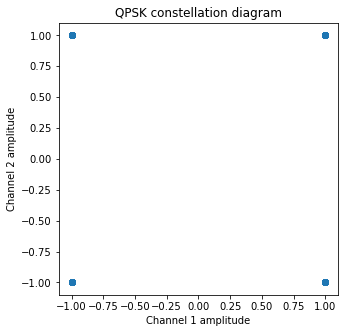

In [15]:
plt.figure(figsize=(5,5))
plt.scatter(np.real(qpsk_symbols), np.imag(qpsk_symbols))
plt.title('QPSK constellation diagram')
plt.xlabel('Channel 1 amplitude')
plt.ylabel('Channel 2 amplitude')
plt.show()

Let's try the same with 16-QAM. This time it's a modulation scheme with 4 levels (or 4 bits per symbol), which means we will need to generate integers in the range of 0-15. Don't forget, when specifying ranges in Python (like the NumPy randint function) the last digit is not inclusive.

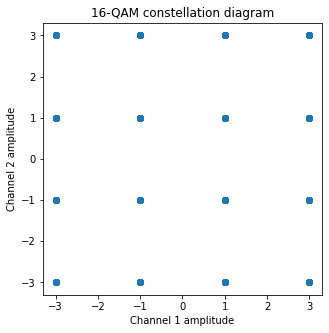

In [21]:
# Generate 16-QAM symbols
qam_scheme = [-3-3j, -3-1j, -3+3j, -3+1j,  \
              -1-3j, -1-1j, -1+3j, -1+1j,  \
               3-3j,  3-1j,  3+3j,  3+1j,  \
               1-3j,  1-1j,  1+3j,  1+1j]
ints = np.random.randint(0,16,1024)
qam_symbols = [qam_scheme[i] for i in ints]

# Plot the mapped symbols
plt.figure(figsize=(5,5))
plt.scatter(np.real(qam_symbols), np.imag(qam_symbols))
plt.title('16-QAM constellation diagram')
plt.xlabel('Channel 1 amplitude')
plt.ylabel('Channel 2 amplitude')
plt.show()

We would proceed similarly with 64-QAM, 128-QAM, etc. With good channel conditions we could go as high as 1024-QAM! The advantage of using higher order modulation schemes is that we can stuff more bits into a single symbol, which can drastically improve our data throughput, however as we will soon find out later in this notebook, this makes our modulated data more susceptible to noise.

## 1.2 Noise and SNR <a class="anchor" id="snr"></a>

The received signal is unlikely to ever be perfect like shown in above constellation graphs, in a real scenario, the received signal will be imperfect due to noise experienced from the environment, including even thermal noise arising from the analog receiver components. It is conventional to model the combined noise arising from all of these sources as Additive White Gaussian Noise (AWGN). Therefore, AWGN is added to the received signal. AWGN follows a gaussian distribution with mean $\mu = 0$, and the variance $\sigma^{2}$ that describes the spread of noise amplitudes.

In Python we can use the *random* module and draw from a gaussian distribution for noise to add to our symbols with $\mu = 0$ and $\sigma^{2} = 1$.

In [22]:
noise = np.random.randn(50000,1)
print("    Mean of my signal: {}".format(np.mean(noise)))
print("Variance of my signal: {}".format(np.var(noise)))

    Mean of my signal: 0.0006512752210366241
Variance of my signal: 0.9944284589442214


While not exactly 0 and 1, the values are pretty close. The more samples we took the closer we would get to the ideal statistical values.

Plotting the samples as a histogram is a great sanity check to confirm that we have a normal distribution. We should see something resembling the characteristic bell curve that we are all too familiar with!

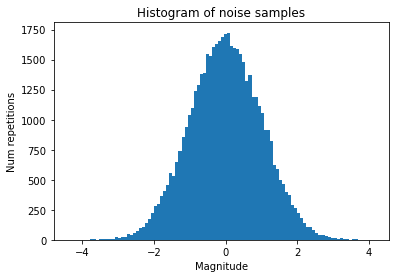

In [23]:
plt.hist(noise, bins=100)
plt.title('Histogram of noise samples')
plt.xlabel('Magnitude')
plt.ylabel('Num repetitions')
plt.show()

The variance of the distribution can be manipulated by multiplying the standard distribution with the square root of the variance. E.g. multiplying our noise vector by 2, gives us the variance of 4.

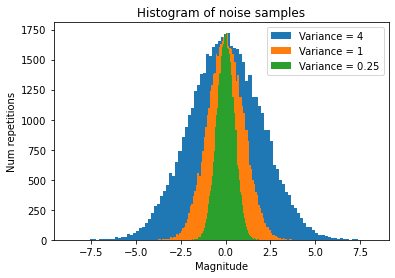

In [24]:
plt.hist(noise*2, bins=100)
plt.hist(noise, bins=100)
plt.hist(noise*0.5, bins=100)
plt.title('Histogram of noise samples')
plt.xlabel('Magnitude')
plt.ylabel('Num repetitions')
plt.legend(('Variance = 4', 'Variance = 1', 'Variance = 0.25'))
plt.show()

**Signal to Noise Ratio**

When talking about noise, we must talk about a very useful measure called the Signal to Noise Ratio (SNR). It is simply the ratio of the power of the signal of interest and the power of the noise.

$SNR = P_{s}/P_{n}$

SNR is most often talked about in terms of decibels (dB), in which case life becomes easier and we can use subtraction instead of division.

$SNR(dB) = P_{s}(dB) - P_{n}(dB)$

Let's say we want to add noise to our QPSK signal so that the SNR is 20dB. First we need to measure the power of our signal.

In [25]:
snr = 10 # specify SNR in dB
sig_power = np.mean(np.abs(qpsk_symbols)**2) # calculate signal power
sig_power_db = 10* np.log10(sig_power) # convert to dB

Recall that $SNR = P_{s}/P_{n}$, which is equivalent to $SNR(dB) = P_{s}(dB) - P_{n}(dB)$. Now that we have our signal power and desired SNR, we can easily calculate the power of our desired noise signal.

In [26]:
noise_power_db = sig_power_db - snr
noise_power = 10**(noise_power_db / 10)

Now generate a noise signal with the desired noise power. Note that we have a division by 2 in the code, which is added because we are dealing with complex signals - if we were dealing with a single channel real signal we would simply multiply our random noise samples by the square root of the desired noise power.

In [29]:
complex_noise = np.sqrt(noise_power/2)*(np.random.randn(len(qpsk_symbols)) + \
                                        np.random.randn(len(qpsk_symbols))*1j)

Add noise to the QPSK symbols by adding the complex noise samples to the symbols.

In [30]:
qpsk_symbols_noisy = qpsk_symbols + complex_noise

Plot the noisy QPSK constellation. The red markers showing the ideal constellation points for the QPSK modulation scheme help to demonstrate the amount of error in the received signal samples. We can still see 4 distinct clusters and could receive our data relatively error-free.

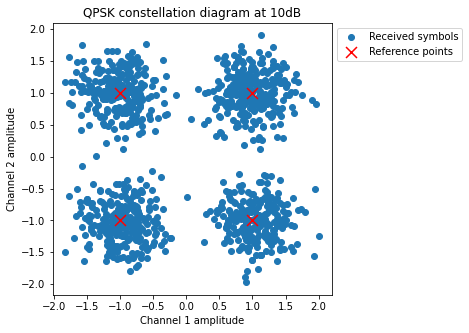

In [36]:
plt.figure(figsize=(5,5))
plt.scatter(qpsk_symbols_noisy.real, qpsk_symbols_noisy.imag)
plt.scatter(np.real(qpsk_scheme), np.imag(qpsk_scheme), s=120, c='red', marker='x')
plt.title('QPSK constellation diagram at 10dB')
plt.xlabel('Channel 1 amplitude')
plt.ylabel('Channel 2 amplitude')
plt.legend(('Received symbols', 'Reference points'), \
           bbox_to_anchor=(1, 1), loc='upper left')

To make life a bit easier for ourselves we can create a functon that applies noise to our constellations, since we will be doing that multiple more times in this notebook.

In [32]:
def awgn(signal, snr):
    sig_power = np.mean(np.abs(signal)**2) # calculate signal power
    sig_power_db = 10* np.log10(sig_power) # convert to dB

    noise_power_db = sig_power_db - snr
    noise_power = 10**(noise_power_db / 10)

    complex_noise = np.sqrt(noise_power/2)*(np.random.randn(len(signal)) + \
                                            np.random.randn(len(signal))*1j)

    return signal + complex_noise

Let's try adding noise to a 16-QAM signal as well so that the SNR is 20dB. We can still see very nice distinct clusters. 

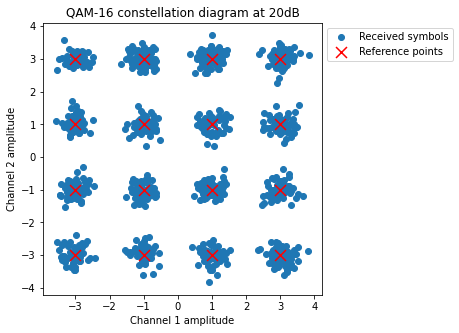

In [33]:
# Apply white noise to our signal so that the SNR is 20dB
qam_symbols_20db = awgn(qam_symbols, 20)

plt.figure(figsize=(5,5))
plt.scatter(qam_symbols_20db.real, qam_symbols_20db.imag)
plt.scatter(np.real(qam_scheme), np.imag(qam_scheme), s=120, c='red', marker='x')
plt.title('QAM-16 constellation diagram at 20dB')
plt.xlabel('Channel 1 amplitude')
plt.ylabel('Channel 2 amplitude')
plt.legend(('Received symbols', 'Reference points'), \
           bbox_to_anchor=(1, 1), loc='upper left')

What would happen if we reduced the SNR down to 10dB?

In [34]:
qam_symbols_10db = awgn(qam_symbols,10)

After plotting, note how much more difficult it is to tell the clusters apart, even though it's the same noise ratio as we experienced with QPSK. This is why in practical communication systems the modulation scheme is usually adaptable based on the SNR being observed - if we are experiencing poor SNR we might switch from 16-QAM to QPSK, whereas at really high SNR values we could go as high as 4096-QAM!

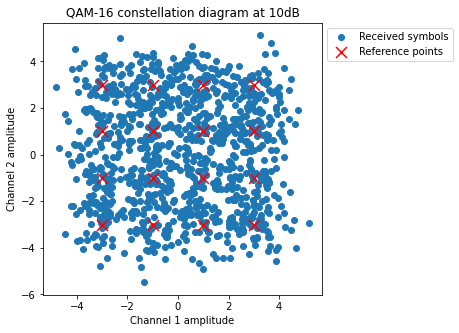

In [35]:
plt.figure(figsize=(5,5))
plt.scatter(qam_symbols_10db.real, qam_symbols_10db.imag)
plt.scatter(np.real(qam_scheme), np.imag(qam_scheme), s=120, c='red', marker='x')
plt.title('QAM-16 constellation diagram at 10dB')
plt.xlabel('Channel 1 amplitude')
plt.ylabel('Channel 2 amplitude')
plt.legend(('Received symbols', 'Reference points'), \
           bbox_to_anchor=(1, 1), loc='upper left')

We can decide pretty well by just looking at these diagrams whether the quality of our received constellations is good or not. But we can also look at defined metrics engineers use to evaluate the quality of these received signals. One of the key metrics is Error Vector Magnitude (EVM), which we will cover next.

## 1.3 Error Vector Magnitude <a class="anchor" id="evm"></a>

One way of evaluating the quality of the received signals is by calculating the Error Vector Magnitude (EVM). It is defined as the magnitude of the vector between the received and reference samples points, as a ratio with respect to the magnitude of the reference sample point. Typically it is measured by taking the average over a large number of samples to get a meaningful value.

It is defined as

$EVM = \frac{\sqrt{\frac{1}{N} \sum^{N}_{n=1}(I_{rx}(n)-I_{0}(n))^2 + (Q_{rx}(n) - Q_{0}(n))^2}}{\sqrt{I_{0}^2 + Q_{0}^2}}$

Now that we have a noisy QAM signal we can calculate the EVM value with respect to the generated clean QAM symbols. Once again in Python we can take advantage of vectorization and using *np.abs* instead of squaring and square rooting. EVM is commonly expressed as a percentage so we will be returning a value of our ratio multiplied by 100.

In [37]:
def calculate_evm(symbols_tx, symbols_rx):
    evm_rms = np.sqrt(np.mean(np.abs(symbols_rx - symbols_tx )**2)) / \
              np.sqrt(np.mean(np.abs(symbols_tx)**2))
    
    return evm_rms*100

In [38]:
print("QAM-16 EVM at 20dB: {:.2f}%".format(calculate_evm(qam_symbols_20db, qam_symbols)))

QAM-16 EVM at 20dB: 9.90%


Our EVM at 20dB SNR for 16-QAM is only 10%, not bad! What if we used our example data with 10dB SNR?

In [39]:
print("QAM-16 EVM at 10dB: {:.2f}%".format(calculate_evm(qam_symbols_10db, qam_symbols)))

QAM-16 EVM at 10dB: 30.55%


As you can see the error magnitude is now around 30%! If we added even more noise this would be problematic and based on this measure, we might decide to use a less complex modulation scheme, such as QPSK.

## 1.4 Bit Error Rate <a class="anchor" id="ber"></a>

The Bit Error Rate (BER) is simply defined as the ratio between the number of errors in received bits, $N_e$, and the total number of bits transmitted $N$. 

$BER = \frac{N_e}{N}$

Let's define a BPSK demodulation function so we can more easily recover bits in a 'for' loop that we will construct to calculate SNR over a range of $E_{b}/N_{o}$ values. In the case of BPSK we simply check whether our constellation point ended up on the left or right of the Y axis, then the circuit can simply output a 1 or a 0.

In [26]:
def bpsk_demodulate(symbols):
    demodded = [None]*len(symbols)
    
    for i, symbol in enumerate(symbols):
        if symbol.real >= 0:
            demodded[i] = 1
        else:
            demodded[i] = 0
            
    return np.array(demodded)

Usually we measure BER over a range of normalized SNR values, denoted as $E_b/N_o$, standing for energy efficiency per bit (Eb) over the noise spectral density or noise per 1Hz of bandwidth. Usually what we will do is specify a a range of $E_b/N_o$ values and calculate the corresponding SNR value based on the (in this case) modulation order.

We use $SNR = E_b/N_o + 10log10(k) - 10log10(n)$, where $n$ is samples per symbol, and $k$ is number of bits per symbol. Since we are not performing any pulse shaping here, the sampling rate is equivalent to the symbol rate and our value of $n$ will be 1. For a binary modulation scheme like BPSK, $k$ is also 1, and therefore the second and third terms cancel, and SNR is equal to $E_b/N_0$ in this case. For more in-depth information refer to Bernard Sklar’s book “Digital Communications: Fundamentals and Applications”.

BER graphs are plotted on a logarithmic scale. We will run this loop for a large number of iterations for each $E_b/N_o$ value to produce a nice smooth graph.

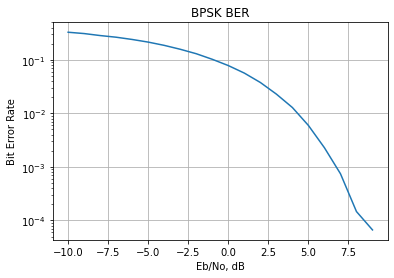

In [27]:
ebno_range = np.arange(-10,10)
ber_bpsk = []

for ebno in ebno_range:
    # Generate random bits
    bits_tx = np.random.randint(0,2,75000)
    
    # Map our bits to BPSK symbols
    bpsk_symbols = [bpsk_scheme[i] for i in bits_tx]
    
    # Pass symbols through awgn channel
    bpsk_symbols_tx = awgn(bpsk_symbols, ebno)
    
    # Recover bits from noisy constellations
    bits_rx = bpsk_demodulate(bpsk_symbols_tx)
    
    # Calculate BER and append to list
    ber_bpsk.append((len(bits_tx)-sum(bits_rx==bits_tx))/len(bits_tx))
    
plt.semilogy(ebno_range,ber_bpsk)
plt.xlabel('Eb/No, dB')
plt.ylabel('Bit Error Rate')
plt.title('BPSK BER')
plt.grid()

QPSK and higher order QAM signals will be slightly more complex than our BPSK example. Defining our QPSK demodulator function we already see the number of outcomes double.

In [28]:
def qpsk_demodulate(symbols):
    demodded_symbols = [None]*len(symbols)
    
    for i,symbol in enumerate(symbols):
        if symbol.real >= 0:
            if symbol.imag >= 0:               # upper right quadrant ++
                demodded_symbols[i] = 0
            else:                              # lower right quadrant +-
                demodded_symbols[i] = 1
        else:
            if symbol.imag >= 0:               # upper left quadrant -+
                demodded_symbols[i] = 2
            else:                              # lower left quadrant --
                demodded_symbols[i] = 3
    
    return np.array(demodded_symbols)

Also since the QPSK modulation scheme uses 2 bits to represent 1 symbol, we employ an additional lookup dictionary so we can convert our recovered QPSK symbols into bits.

In [29]:
# We'll use this dictionary to map our integers into bits for QPSK BER
binary_mapping = {0 : (0, 0),
                  1 : (0, 1),
                  2 : (1, 0),
                  3 : (1, 1)}

Just like the BPSK plot, we will run this for many thousands of iterations. Do note that now we have 2 output lists defined - *ser_qpsk* and *ber_qpsk*. SER in this case stands for Symbol Error Rate and while BER == SER for the BPSK case, the SER will differ for QPSK and higher order QAM modulations since they use more than 1 bit to represent a symbol.

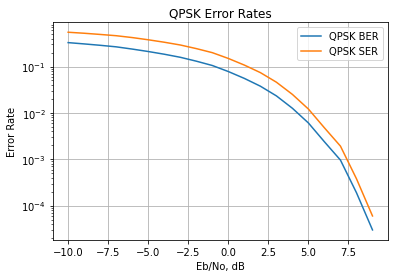

In [30]:
ebno_range = np.arange(-10,10)
ser_qpsk, ber_qpsk = [], []

for ebno in ebno_range:
    # Generate random integers
    ints_tx = np.random.randint(0,4,50000)
    
    # Map them to symbols given our QPSK scheme
    qpsk_symbols = [qpsk_scheme[i] for i in ints_tx]
    
    # Add noise for each Eb/No value
    snr = ebno + 10*np.log10(2)
    qpsk_symbols_tx = awgn(qpsk_symbols,snr)
    
    # Recover symbols from the noisy constellations
    ints_rx = qpsk_demodulate(qpsk_symbols_tx)
    
    # Calculate SER and append to list
    ser_qpsk.append((len(ints_tx)-sum(ints_rx==ints_tx))/len(ints_tx))
    
    # convert to bits
    bits_tx = np.array([binary_mapping[symbol] for symbol in ints_tx]).reshape(-1)
    bits_rx = np.array([binary_mapping[symbol] for symbol in ints_rx]).reshape(-1)
    
    # Calculate BER and append to list
    ber_qpsk.append(np.sum(bits_tx != bits_rx)/len(bits_tx))
    
plt.semilogy(ebno_range,ber_qpsk)
plt.semilogy(ebno_range,ser_qpsk)
plt.title('QPSK Error Rates')
plt.xlabel('Eb/No, dB')
plt.ylabel('Error Rate')
plt.legend(('QPSK BER', 'QPSK SER'))
plt.grid()

As we can see with the case of QPSK, all higher order modulation schemes will have a higher SER. But a high SER doesn't mean that we will not get **some** of the bits correct. I.e. if we receive a QPSK symbol carrying bits '10', while a '11' was sent, so while the symbol is incorrect, we still received half of the bits correctly.

## 1.5 Conclusion <a class="anchor" id="conclusion"></a>

In this notebook we covered some of the more common baseband modulation schemes, noise and how to measure the quality of our communication system using EVM and BER. In the next notebook we will look at why one may want to modify these symbol pulses before transmission, by using pulse shaping filters.

[Next Notebook ➡️](02_pulse_shaping.ipynb)

----
----